In [1]:
import sqlite3
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import numpy as np
# paths to local databases
# path to databases
data_folder = './../../../s3/data'
city_geom  = data_folder + '/d000_lookuptables/city_pts_urban_audit2021.sqlite'
fua_geom   = data_folder + '/d000_lookuptables/fua_pts_urban_audit2021.sqlite'
lookuptable= data_folder + '/d000_lookuptables/lookuptables.gpkg'
city_cube  = data_folder + '/c001_city_cube/C_urban_cube_sh.sqlite'

## Get the Eurostat Table and attribute description, city names

In [2]:
# get Eurostat variables
con = sqlite3.connect(city_cube)
# read full table
eurostat_all = pd.read_sql_query("SELECT * FROM c_urban_cube_eurostat", con)
con.close()
eurostat_all

,index,indic_code,urau_code,1991,1992,1993,1994,1995,1996,1997,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,0,EN1002V,AT001C,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,EN1002V,AT002C,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,EN1002V,AT003C,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,EN1002V,AT004C,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,EN1002V,AT005C,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47683,6132,TT1080V,UK024C,None,None,None,None,None,None,None,...,NaN,51.3,45.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47684,6133,TT1080V,UK027C,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47685,6134,TT1080V,UK029C,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,102.61,NaN,NaN,NaN,NaN,NaN
47686,6135,TT1080V,UK030C,None,None,None,None,None,None,None,...,NaN,NaN,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# also get lookup tables with attribute description and city names
con_l = sqlite3.connect(lookuptable)
eurostat_attributes = pd.read_sql_query("SELECT * FROM L_eurostat", con_l)
city_names = pd.read_sql_query("SELECT URAU_CODE, URAU_NAME FROM L_core_city_urb_atl18", con_l)
con_l.close()
# city code has a trailing number, lets drop it for now
city_names.URAU_CODE = city_names.URAU_CODE.str[:-1]

In [4]:
# join tables with two consecutive merge (dropping rows that do not match) 
eurostat_extended = eurostat_all.merge(
    city_names, how="inner", left_on="urau_code", right_on="URAU_CODE").merge(
    eurostat_attributes, how="inner", left_on="indic_code", right_on="variable_code")
# drop duplicated columns
eurostat_extended.drop(columns=["index_x", "index_y", "variable_code", "URAU_CODE"], inplace=True)

## Code significance  
indic_code (type of data): e.g., DE1001V = total population (see: https://www.espon.eu/sites/default/files/attachments/CB02_Inception_report_Annex_I.pdf) 

City name from urau_code, here: https://ec.europa.eu/eurostat/documents/3217494/5729233/RY_CH_ANNEXES_2011-EN.PDF.pdf/deb1dbbc-e8d3-4dd2-aa76-fae2f36a0bd9?t=1414776025000 

In [5]:
eurostat_extended.head()

,indic_code,urau_code,1991,1992,1993,1994,1995,1996,1997,1998,...,2016,2017,2018,2019,2020,2021,URAU_NAME,eurostat_table,variable_description,uc1_priority
0,EN1002V,AT001C,None,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,Wien,urb_cenv,Total number of hours of sunshine per day,2
1,EN1002V,AT002C,None,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,Graz,urb_cenv,Total number of hours of sunshine per day,2
2,EN1002V,AT003C,None,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,Linz,urb_cenv,Total number of hours of sunshine per day,2
3,EN1002V,AT004C,None,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,Salzburg,urb_cenv,Total number of hours of sunshine per day,2
4,EN1002V,AT005C,None,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,Innsbruck,urb_cenv,Total number of hours of sunshine per day,2


In [6]:
print('Features: ', eurostat_extended.variable_description.unique())
print('Number of Features: ', len(eurostat_extended.variable_description.unique()))

Features:  ['Total number of hours of sunshine per day'
 'Average temperature of warmest month - degrees'
 'Average temperature of coldest month - degrees' 'Rainfall - litre/m²'
 'Number of days ozone O3 concentrations exceed 120 µg/m³'
 'Number of hours nitrogen dioxide NO2 concentrations exceed 200 µg/m³'
 'Number of days particulate matter PM10 concentrations exceed 50 µg/m³'
 'Accumulated ozone concentration in excess 70 µg/m³'
 'Annual average concentration of NO2 (µg/m³)'
 'Annual average concentration of PM10 (µg/m³)' 'Total use of water - m³'
 'Price of a m³ of domestic water - Euro'
 'Share of the urban waste water load (in population equivalents) treated according to the applicable standard -%'
 'Municipal waste generated (domestic and commercial), total - 1000 t'
 'Number of deaths per year under 65 due to diseases of the circulatory or respiratory systems'
 'Total deaths under 65 per year' 'Total deaths per year'
 'Share of severely materially deprived persons -%'
 'Share o

## Study data availability across cities and years
- how many years with data

In [7]:
# make availability matrix
# drop descriptive columns, keep only value columns, i.e. years
av_table = eurostat_extended.drop(columns=["indic_code", "urau_code", "URAU_NAME", "eurostat_table", "variable_description", "uc1_priority"])
av_matrix = ~pd.isnull(av_table)
# sum over rows: returns the number of years with non-null data
cities_av = av_matrix.sum(axis=1)
# sum over columns: returns the number of available cities for that year
years_av = av_matrix.sum(axis=0)

<Axes: >

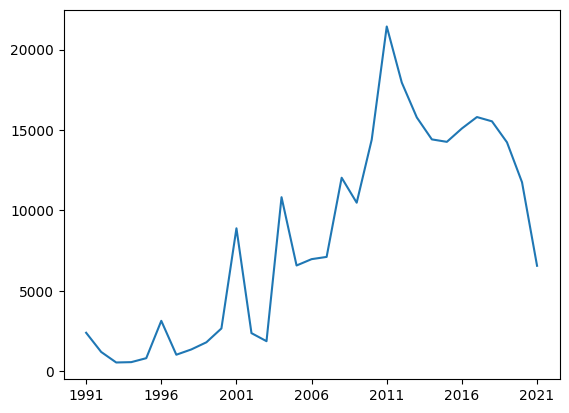

In [8]:
years_av.plot()

### Data gaps exploration
- For each row, get the first and last year with non-null data, the number of years with non-null data, the median and maximum gap between non-null values

In [9]:
import math
def get_data_gaps(av_table):
    av_matrix = ~pd.isnull(av_table)
    av_matrix = av_matrix.astype(int)
    yr_with_values = av_matrix.apply(lambda x: np.where(x.values == 1)[0], axis=1)
    n_years = yr_with_values.apply(lambda x: len(x))
    first_year = yr_with_values.apply(lambda x: 1991+x[0] if len(x) > 0 else 0)
    last_year = yr_with_values.apply(lambda x: 1991+x[-1] if len(x) > 0 else 0)
    gaps = yr_with_values.apply(lambda x: [t - s for s, t in zip(x, x[1:])])
    gaps_max = gaps.apply(lambda x: np.max(x) if len(x) > 0 else 0)
    gaps_median = gaps.apply(lambda x: int(math.ceil(np.median(x))) if len(x) > 0 else 0)
    d = {
        "first_year": first_year,
        "last_year": last_year,
        "n_years": n_years,
        "gap_max": gaps_max,
        "gap_median": gaps_median
    }
    df = pd.DataFrame(data=d)
    return df

In [10]:
%time
data_av = get_data_gaps(av_table)

CPU times: user 0 ns, sys: 2 µs, total: 2 µs
Wall time: 4.29 µs


In [11]:
eurostat_extended2 = eurostat_extended.merge(data_av,left_index=True, right_index=True)
eurostat_extended2

,indic_code,urau_code,1991,1992,1993,1994,1995,1996,1997,1998,...,2021,URAU_NAME,eurostat_table,variable_description,uc1_priority,first_year,last_year,n_years,gap_max,gap_median
0,EN1002V,AT001C,None,None,None,None,None,None,None,None,...,NaN,Wien,urb_cenv,Total number of hours of sunshine per day,2,2004,2004,1,0,0
1,EN1002V,AT002C,None,None,None,None,None,None,None,None,...,NaN,Graz,urb_cenv,Total number of hours of sunshine per day,2,2001,2004,2,3,3
2,EN1002V,AT003C,None,None,None,None,None,None,None,None,...,NaN,Linz,urb_cenv,Total number of hours of sunshine per day,2,2001,2004,2,3,3
3,EN1002V,AT004C,None,None,None,None,None,None,None,None,...,NaN,Salzburg,urb_cenv,Total number of hours of sunshine per day,2,2001,2004,2,3,3
4,EN1002V,AT005C,None,None,None,None,None,None,None,None,...,NaN,Innsbruck,urb_cenv,Total number of hours of sunshine per day,2,2001,2004,2,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34928,SA1053V,PT011C,None,None,None,None,None,None,None,None,...,1226.0,Amadora,urb_clivcon,Average price for buying an apartment per m2 ...,1,2017,2021,5,1,1
34929,SA1053V,PT013C,None,None,None,None,None,None,None,None,...,1562.0,Odivelas,urb_clivcon,Average price for buying an apartment per m2 ...,1,2017,2021,5,1,1
34930,SA1053V,PT014C,None,None,None,None,None,None,None,None,...,1536.0,Viseu,urb_clivcon,Average price for buying an apartment per m2 ...,1,2017,2021,5,1,1
34931,SA1053V,PT002C,None,None,None,None,None,None,None,None,...,1810.0,Porto,urb_clivcon,Average price for buying an apartment per m2 ...,1,2017,2021,5,1,1


### Select variables with _sufficient_ data
Criteria:
- for each city, the maximum gap between non-null values is 3
- for each city there are at least 5 non-null values
- at least 101 cities reported this indicator

In [12]:
indicator_stats_max_gap = eurostat_extended2[
    (eurostat_extended2.gap_max < 4) &
    (eurostat_extended2.n_years > 4)].groupby('indic_code').agg({'gap_max': 'mean',
    'urau_code': 'count',
    'n_years': ['min', 'max', 'mean'],
    'first_year': 'min',
    'last_year': 'max'})
indicator_stats_max_gap.dropna(inplace=True)
indicator_stats_max_gap.columns =  ['_'.join(col) for col in indicator_stats_max_gap.columns]
sel_indic = indicator_stats_max_gap[indicator_stats_max_gap.urau_code_count > 100]

In [13]:
sel_indic = sel_indic.merge(
    eurostat_attributes, how="inner", left_on="indic_code", right_on="variable_code")
sel_indic["variable_description"].unique()

array(['Number of public swimming pools (indoor and outdoor, excluding beaches)',
       'Population on the 1st of January, total',
       'Population on the 1st of January, 55-64 years, total',
       'Population on the 1st of January, 65-74 years, total',
       'Population on the 1st of January, 0-4 years, total',
       'Population on the 1st of January, 15-19 years, total',
       'Population on the 1st of January, 20-24 years, total',
       'Population on the 1st of January, 75 years and over, total',
       'Population on the 1st of January, 25-34 years, total',
       'Population on the 1st of January, 35-44 years, total',
       'Population on the 1st of January, 45-54 years, total',
       'Median population age',
       'Population on the 1st of January, 5-9 years, total',
       'Population on the 1st of January, 10-14 years, total',
       'Economically active population, total',
       'Persons unemployed, total',
       'Economically active population 55-64, total',
   

In [14]:
print('Number of Features: ', len(sel_indic.variable_description.unique()))

Number of Features:  39


## Cities eligible for gap filling
- Save the selected indicator codes in a list. We will consider from now on only those indicators
- We build two datasets:
    - `train_data`: rows that are "almost" complete, that is, city/indicator with at most 1-year gap and at least 11 values
    - `test_data`: rows with gaps of 2 or 3 years, and between 5 and 10 values. These rows are eligible for gap-filling

In [24]:
selected_indicator_codes = sel_indic.variable_code
train_data = eurostat_extended2[(eurostat_extended2.indic_code.isin(selected_indicator_codes)) &
                  (eurostat_extended2.gap_max < 2) &
                (eurostat_extended2.n_years > 10)].groupby("indic_code").agg({
    'urau_code': ['count', lambda x: list(x)]})
test_data = eurostat_extended2[(eurostat_extended2.indic_code.isin(selected_indicator_codes)) &
                  (eurostat_extended2.gap_max >= 2) & (eurostat_extended2.gap_max < 4) &
                (eurostat_extended2.n_years <= 10) & (eurostat_extended2.n_years > 4)].groupby("indic_code").agg({
    'urau_code': ['count', lambda x: list(x)]})

In [25]:
train_data

urau_code                                                   
               count                                         <lambda_0>
indic_code                                                             
CR1015V           81  [DE001C, DE005C, DE007C, DE009C, DE010C, DE013...
DE1001V          270  [BE001C, BE002C, BE003C, BE004C, BE006C, BE007...
DE1025V          127  [BE007C, DE041C, DE042C, DE043C, DE044C, DE045...
DE1028V          113  [BE007C, DE041C, DE042C, DE045C, DE046C, DE049...
DE1040V          164  [BE007C, BE008C, BE009C, BE010C, BE011C, DE041...
DE1046V          186  [DE041C, DE042C, DE043C, DE044C, DE045C, DE046...
DE1049V          186  [DE041C, DE042C, DE043C, DE044C, DE045C, DE046...
DE1055V          113  [BE007C, DE041C, DE042C, DE045C, DE046C, DE049...
DE1058V          145  [BG001C, BG002C, BG003C, BG004C, BG005C, BG006...
DE1061V          145  [BG001C, BG002C, BG003C, BG004C, BG005C, BG006...
DE1064V          145  [BG001C, BG002C, BG003C, BG004C, BG005C, BG006...
DE1073V          127  [FI001C, FI002C, FI003C, FI004C, FR003C, FR004...
DE1074V          339  [BG001C, BG002C, BG003C, BG004C, BG005C, BG006...
DE1077V          339  [BG001C, BG002C, BG003C, BG004C, BG005C, BG006...
EC1002V           79  [DE041C, DE042C, DE043C, DE044C, DE045C, DE046...
EC1010V           79  [DE041C, DE042C, DE043C, DE044C, DE045C, DE046...
EC1145V           72  [DE041C, DE042C, DE043C, DE044C, DE045C, DE046...
EC1174V          130  [DE001C, DE002C, DE003C, DE004C, DE005C, DE006...
EC1177V          198  [DE001C, DE002C, DE003C, DE004C, DE005C, DE006...
EC1180V          130  [DE001C, DE002C, DE003C, DE004C, DE005C, DE006...
EN2002V          131  [AT001C, AT002C, AT003C, AT004C, AT005C, BE001...
EN2003V          144  [AT001C, AT002C, AT003C, AT004C, BE001C, BE003...
EN2005V           99  [AT001C, AT002C, AT003C, AT004C, BE001C, BE003...
EN2025V          134  [AT001C, AT002C, AT003C, AT004C, AT005C, BE001...
EN2026V          143  [AT001C, AT002C, AT003C, AT004C, BE001C, BE003...
EN2027V          103  [AT001C, AT002C, AT003C, AT004C, BE001C, BE003...
EN4008V          155  [BE001C, BE004C, BE005C, BE007C, BE009C, DE001...
SA1001V          139  [CH009C, DE041C, DE042C, DE043C, DE044C, DE045...
SA2013V           45  [CH009C, LV003C, CH007C, IT032C, IT033C, IT034...
SA2016V           79  [FR006C, FR008C, FR009C, FR010C, FR012C, FR013...
SA2019V          192  [DE040C, DE041C, DE045C, DE049C, DE052C, DE053...
SA3005V           16  [CH009C, DE040C, DE080C, DE081C, DE082C, PT001...
TT1060V          148  [BG001C, BG002C, BG003C, BG004C, BG005C, BG006...
TT1079V           19  [DE008C, DE015C, DE027C, DE035C, DE039C, DE041...
TT1080V           31  [BG001C, BG002C, BG003C, BG004C, BG005C, BG006...

## Save to database
TODO

In [16]:
# create new flag column 'selected'
sql_query_create_col = "ALTER TABLE public.c_city_eurostat ADD COLUMN selected int DEFAULT 0"
# populate flag column
sql_query_update = f"UPDATE public.c_city_eurostat SET selected = 1 WHERE urau_code IN {tuple(selected_city_codes)} AND estat_code IN {tuple(selected_indicator_codes)}"